In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
import cv2

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix



In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = int(labels.index(label))
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)).astype('float32') # Reshaping images to preferred size
                resized_arr = np.array(resized_arr)
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
raw_train = get_training_data('../data/train/')

/var/folders/nq/8ndb4d4x7x14kpzhd31gp8f80000gn/T/ipykernel_57170/478339352.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [4]:
raw_val = get_training_data('../data/val/')

/var/folders/nq/8ndb4d4x7x14kpzhd31gp8f80000gn/T/ipykernel_57170/478339352.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [5]:
raw_test = get_training_data('../data/test/')

/var/folders/nq/8ndb4d4x7x14kpzhd31gp8f80000gn/T/ipykernel_57170/478339352.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [6]:
raw_train[0]

array([array([[205., 207., 201., ..., 195., 196., 210.],
              [204., 204., 205., ..., 197., 197., 211.],
              [205., 204., 203., ..., 204., 210., 215.],
              ...,
              [ 18.,  13.,   9., ...,  47.,  50.,  51.],
              [ 13.,  13.,  10., ...,  47.,  47.,  50.],
              [ 13.,  13.,  10., ...,  44.,  45.,  47.]], dtype=float32),
       0], dtype=object)

In [7]:
len(raw_train)

5216

In [8]:
unique, counts = np.unique(raw_train[:,1], return_counts=True)
print(np.asarray((unique, counts)).T)

[[0 3875]
 [1 1341]]


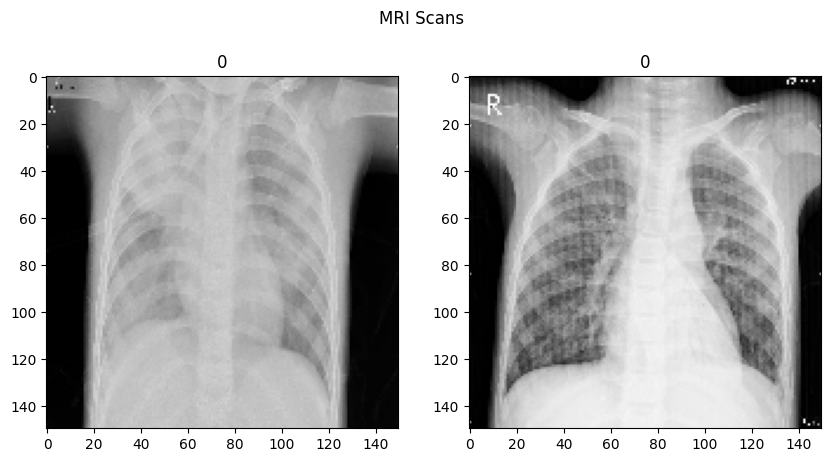

In [9]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(raw_train[49][0], cmap="gray")
plt.title(raw_train[49][1])
# Second subplot
plt.subplot(1,2,2) 
plt.imshow(raw_train[100][0], cmap="gray")
plt.title(raw_train[100][1])
# Global figure methods
plt.suptitle('MRI Scans')
plt.show()

In [10]:
raw_train[:,1]

array([0, 0, 0, ..., 1, 1, 1], dtype=object)

In [11]:
len(raw_train)

5216

In [12]:
train = raw_train[2534:]

In [13]:
len(train)

2682

In [14]:
X_train = []
y_train = []

X_val = []
y_val = []

X_test = []
y_test = []

for feature, label in train:
    X_train.append(feature)
    y_train.append(label)
    
for feature, label in raw_test:
    X_test.append(feature)
    y_test.append(label)
    
for feature, label in raw_val:
    X_val.append(feature)
    y_val.append(label)

In [15]:
X_train = np.array(X_train) / 255
X_test = np.array(X_test) / 255
X_val = np.array(X_val) / 255

In [16]:
X_train = X_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

In [17]:
X_test = X_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [18]:
X_val = X_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [19]:
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  0 390]
 [  1 234]]


In [20]:
from tensorflow.keras import models
from tensorflow.keras import Sequential, layers
from tensorflow.keras import optimizers
adam_opt = optimizers.legacy.Adam()


2023-03-19 15:14:46.489284: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
model = models.Sequential()

model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(150,150, 1)))

model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(layers.Dropout(0.1))


model.add(layers.Conv2D(16, kernel_size=(3), activation='relu')) # kernel_size = 3 <==> (3, 3)

model.add(layers.Flatten())


model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='softmax'))

# Classification with 2 classes
model.compile(loss='binary_crossentropy', 
              optimizer=adam_opt,
              metrics=['accuracy'])


In [ ]:
from tensorflow.keras import callbacks

es = callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train,
          batch_size=32, # Batch size -too small--> no generalization
          epochs=10,    #            -too large--> slow computations
          validation_data=(X_val, y_val),
          callbacks=[es],
          shuffle=True,
          verbose=1)

Epoch 1/10
84/84 [==============================] - 17s 196ms/step - loss: 0.5362 - accuracy: 0.5000 - val_loss: 0.7976 - val_accuracy: 0.5000
Epoch 2/10
84/84 [==============================] - 16s 193ms/step - loss: 0.1010 - accuracy: 0.5000 - val_loss: 0.6568 - val_accuracy: 0.5000
Epoch 3/10
84/84 [==============================] - 16s 193ms/step - loss: 0.0473 - accuracy: 0.5000 - val_loss: 0.5461 - val_accuracy: 0.5000
Epoch 4/10
84/84 [==============================] - 17s 204ms/step - loss: 0.0293 - accuracy: 0.5000 - val_loss: 0.3709 - val_accuracy: 0.5000
Epoch 5/10
84/84 [==============================] - 18s 212ms/step - loss: 0.0214 - accuracy: 0.5000 - val_loss: 0.3794 - val_accuracy: 0.5000
Epoch 6/10
84/84 [==============================] - 18s 210ms/step - loss: 0.0320 - accuracy: 0.5000 - val_loss: 0.2775 - val_accuracy: 0.5000
Epoch 7/10
84/84 [==============================] - 18s 209ms/step - loss: 0.0215 - accuracy: 0.5000 - val_loss: 0.3694 - val_accuracy: 0.5000

In [40]:
history.history['val_accuracy']

[0.875, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375]

In [24]:
# predictions = model.predict_on_batch(
#     X_test
# )

In [25]:
# predictions[400]

In [41]:
test_accuracy = model.test_on_batch(
    X_test, y_test, sample_weight=None, reset_metrics=True, return_dict=True
)
test_accuracy

{'loss': 2.040194511413574, 'accuracy': 0.7820512652397156}

In [27]:
predictions = model.predict(
    X_test,
    batch_size=None,
    verbose='auto',
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False
)

20/20 [==============================] - 1s 45ms/step


In [28]:
predictions[500]

array([1.3230657e-06], dtype=float32)

In [62]:
T=0.00001
y_pred = model.predict(X_test)
y_pred_bool = y_pred>=T

print(classification_report(y_test, y_pred_bool))

20/20 [==============================] - 1s 40ms/step
              precision    recall  f1-score   support

           0       0.88      0.87      0.87       390
           1       0.79      0.79      0.79       234

    accuracy                           0.84       624
   macro avg       0.83      0.83      0.83       624
weighted avg       0.84      0.84      0.84       624



In [55]:
predictions = (model.predict(X_test) > 0.0001).astype("int32")
cm = confusion_matrix(y_test,predictions)
cm

20/20 [==============================] - 1s 39ms/step


array([[369,  21],
       [ 68, 166]])

In [58]:
predictions = (model.predict(X_test) > 0.0001).astype("int32")
cm = confusion_matrix(y_test,predictions)
cm

20/20 [==============================] - 1s 39ms/step


array([[369,  21],
       [ 68, 166]])

NameError: name 'y_pred_' is not defined

In [63]:
filename = '../models/x-ray_model_softmax.pkl'
pickle.dump(model, open(filename, 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......batch_normalization
.........vars
............0
............1
............2
............3
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dropout
.........vars
......flatten
.........vars
......max_pooling2d
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-03-19 09:48:13         4681
metadata.json                                  2023-03-19 09:48:13          